### from astropy.table import Table
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from glob import glob
from spec_tools import Photometry, Posterior_spec, Posterior_SF_spec
from spec_exam import Gen_spec, Gen_SF_spec
from grizli import multifit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import seaborn as sea
import os
import pickle
import numpy as np
import re
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
gndmaster = pd.read_pickle('../dataframes/gndmaster.pkl')
gsdmaster = pd.read_pickle('../dataframes/gsdmaster.pkl')

In [21]:
galid

'18978'

In [6]:
def Plot_all(idx_num,df):
    IDP = df.index.values[idx_num]

    galid = str(df.id[IDP])

    while len(galid) < 5:
        galid = '0' + galid

    subfield = str(df.grism_id_x[IDP])[2:-1].split('-')[0]

    onedlist = glob('/Volumes/Vince_research/Extractions/*/1D/FITS/{0}-*-*{1}*'.format(subfield,galid))
    twodlist = glob('/Volumes/Vince_research/Extractions/*/2D/FITS/{0}-*-*{1}*'.format(subfield,galid))
    
    for i in range(len(onedlist)):
        oned = fits.open(onedlist[i])
        twod = fits.open(twodlist[i])

        gs = GridSpec(2,2,height_ratios=[1,3.5],width_ratios=[1,7],hspace=0.05,wspace=0.02)

        plt.figure(figsize=[12,6])
        plt.subplot(gs[0,0])
        plt.imshow(np.arcsinh(twod['DSCI'].data),cmap='binary')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(gs[0,1])
        plt.imshow(np.arcsinh(twod['SCI'].data - twod['CONTAM'].data),cmap='binary')
        plt.xticks([])
        plt.yticks([])

        wv =oned[1].data['wave']
        fl =(oned[1].data['flux'] - oned[1].data['contam'])/ oned[1].data['sensitivity']
        er =oned[1].data['error'] / oned[1].data['sensitivity']

        IDX = [U for U in range(len(wv)) if 8000 < wv[U] < 11300]

        plt.subplot(gs[1,:])
        plt.errorbar(wv[IDX], fl[IDX]*10, er[IDX]*10,linestyle='None', marker='o', markersize=3, color='k')
        plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
        plt.xlabel('Wavelength ($\\rm \AA$)',size=30)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.savefig('/Volumes/Vince_research/Biopage_plots/North/{0}_{1}_{2}.png'.format(subfield, galid, i+1),bbox_inches = 'tight')

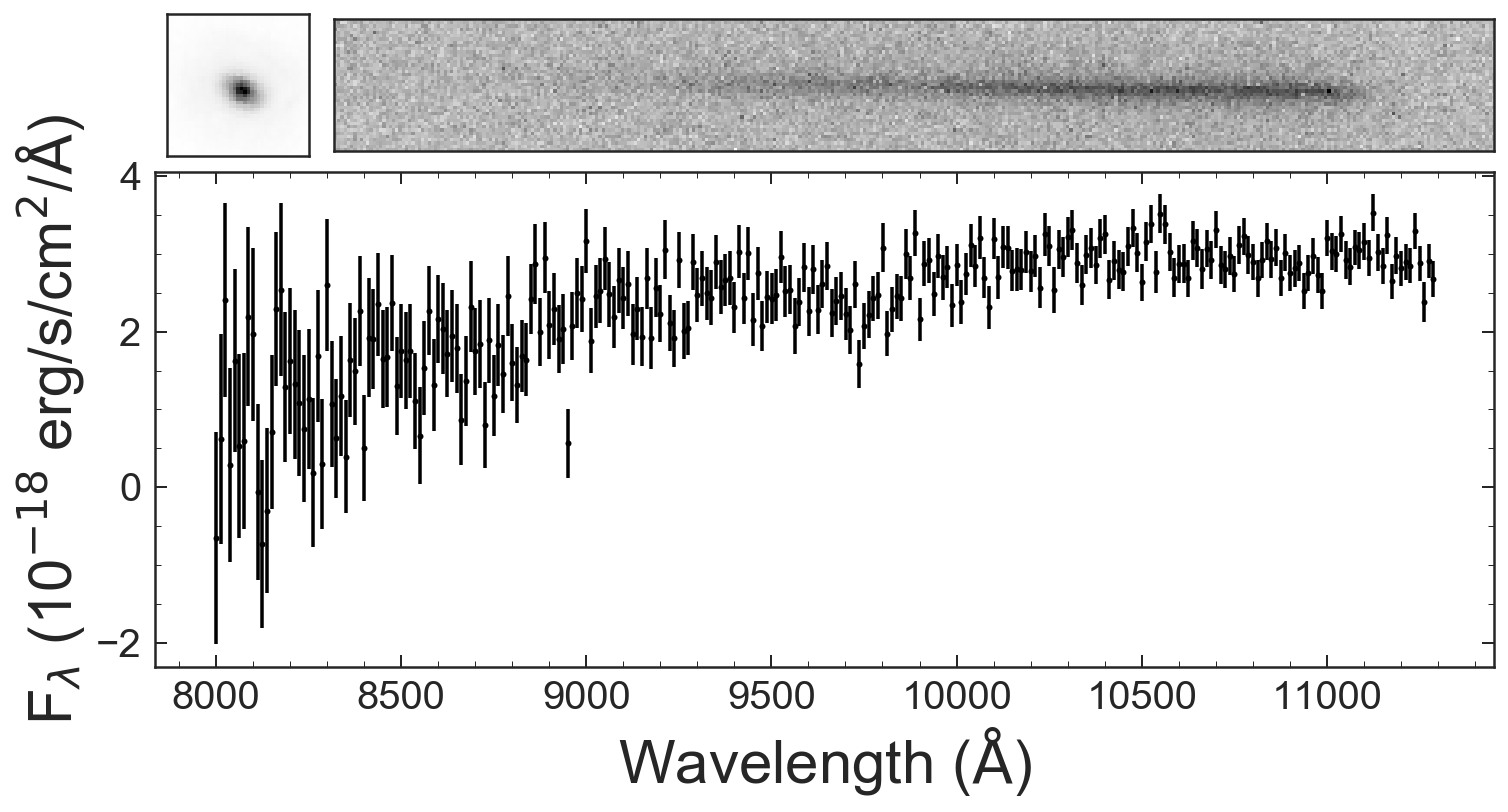

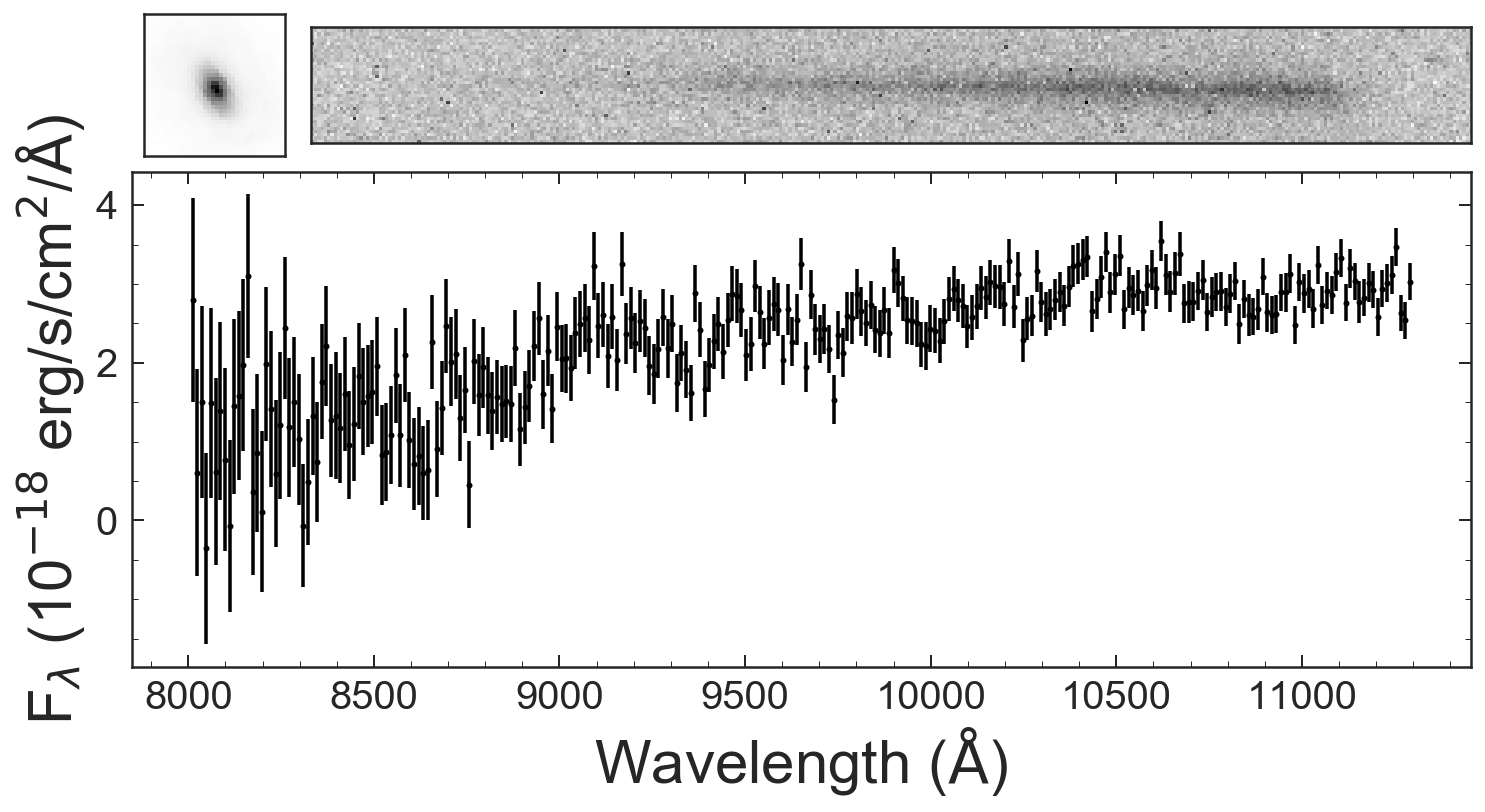

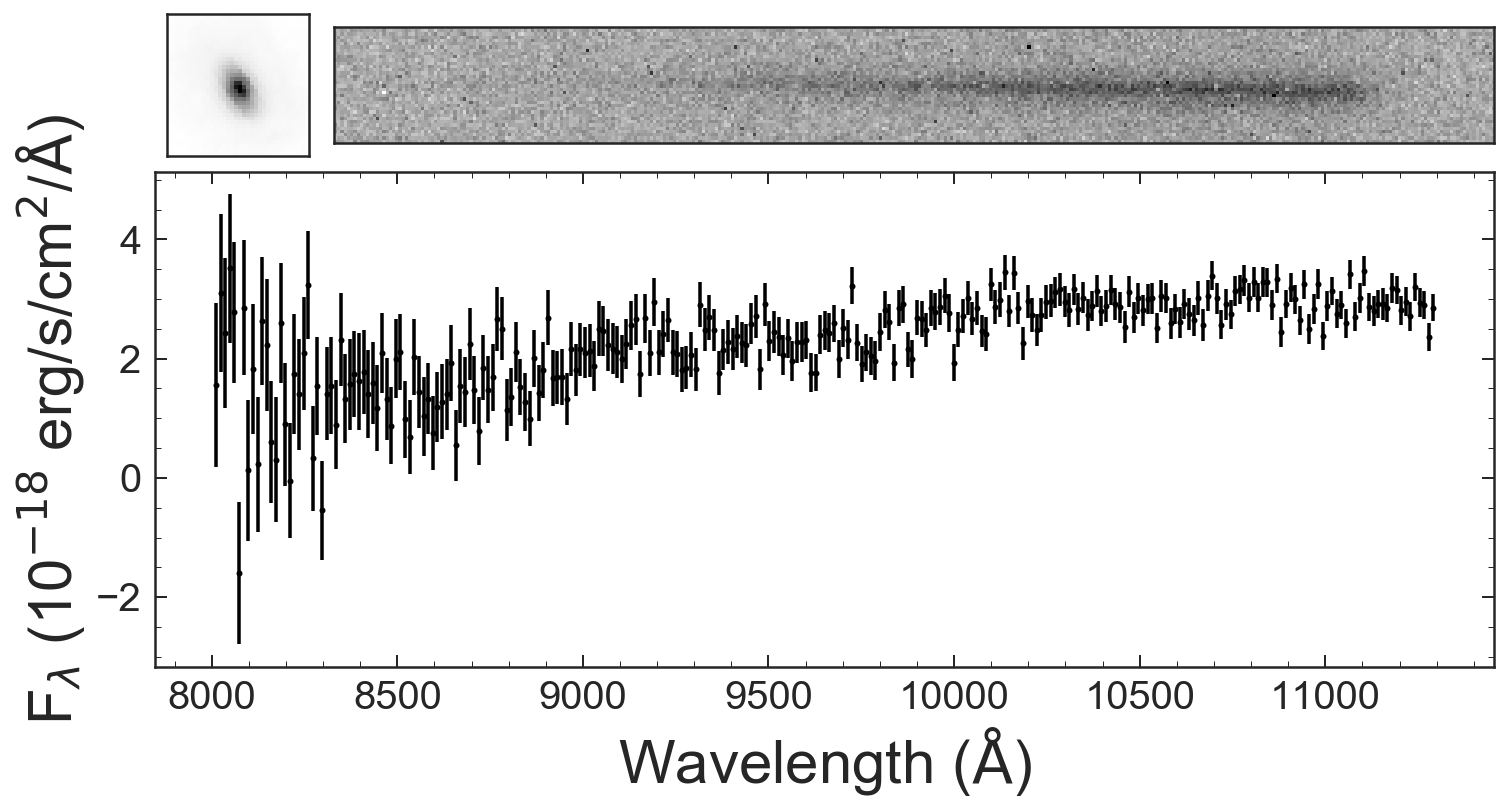

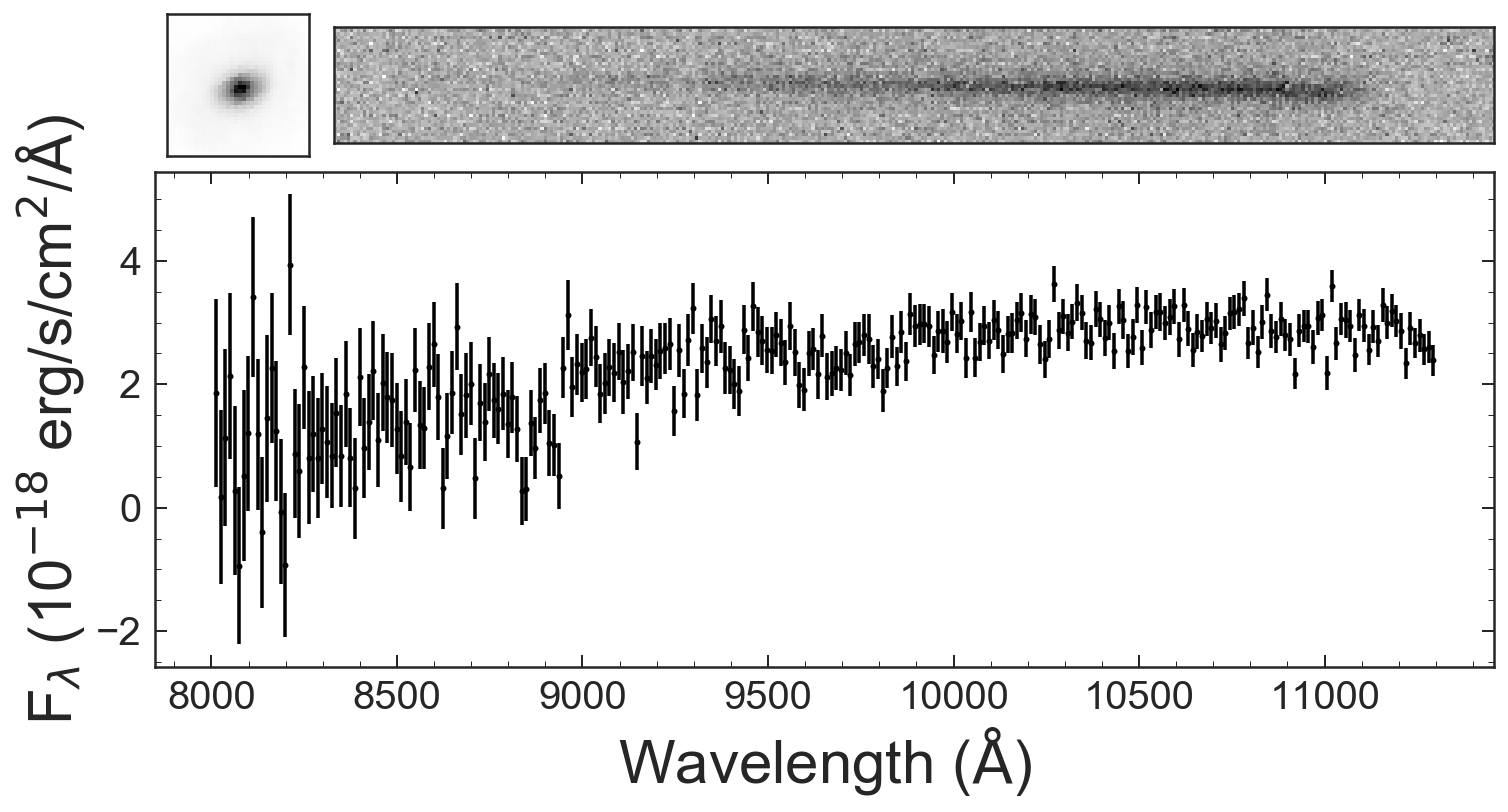

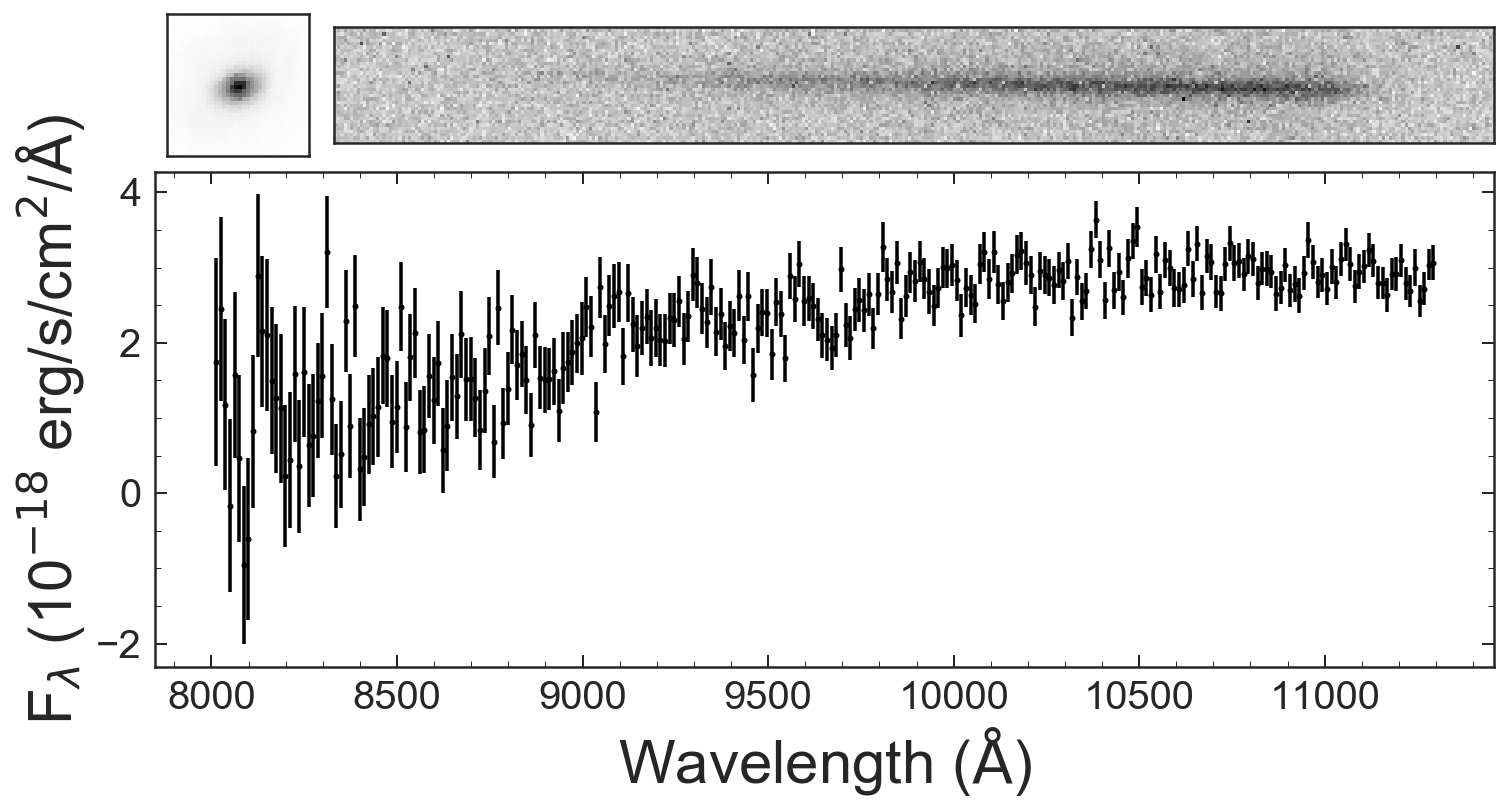

In [7]:
Plot_all(672,gndmaster)

In [79]:
gndmaster.query('id == 21156')

,phot_id_x,grism_id_x,jh_mag_x,z_spec_x,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism_x,...,L271,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275
356,21156,b'GN2-G102_21156',20.716,1.2534,1.2128,1.123,1.172,1.256,1.298,1.2513,...,0.389372,10.0,0.6812,12.0,1.52506,12.0,1.72342,12.0,46.0231,7.0


In [2]:
Bdb = pd.read_pickle('../dataframes/fitdb/buldgefitsdb.pkl')

In [3]:
def plot_posterior(field, galaxy, param, ext, name, x_name, y_name, DB, roundto = 3):
    grow = DB.query('id == {0}'.format(galaxy))
    z,pz = np.load('../data/posteriors/{}_{}_{}_P{}.npy'.format(field, galaxy, ext, param))
    ipz = interp1d(np.round(z,roundto),pz)

    plt.plot(z,pz,'k')
    for i in range(len(grow['{0}_hci'.format(name)].values[0])//2):
        hdr = np.linspace(np.round(grow['{0}_hci'.format(name)].values[0][2*i],roundto),
                          np.round(grow['{0}_hci'.format(name)].values[0][2*i+1],roundto))
        plt.fill_between(hdr, ipz(hdr), color = '#4E7577', alpha=0.75)
    plt.vlines(grow['{0}'.format(name)].values[0],0, ipz(np.round(grow['{0}'.format(name)].values[0],roundto)), color = '#C1253C')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    if max(pz) >= 3:
        plt.yticks(np.linspace(0,max(pz)*1.05,4).astype(int))

def PLOT(field, galaxy, DF, savefig = False):
    grow = DF.query('id == {0}'.format(galaxy))

    flist = glob('../data/posteriors/{}_{}_*_Pm.npy'.format(field, galaxy))
    for f in flist:
        ext = re.split('{}_{}_'.format(field, galaxy),
        re.split('_Pm.npy', os.path.basename(f))[0])[1]
        if ext  == 'tabfit':
            Gs = Gen_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
            Flam = Posterior_spec(field, galaxy)
            break
        if ext in 'SFfit_p1':
            Gs = Gen_SF_spec(field, galaxy, grow.z_grizli.values[0], phot_errterm = 0.04, irac_err = 0.08) 
            Flam = Posterior_SF_spec(field, galaxy, grow.z_grizli.values[0])
            break

    
    x,px = np.load('../data/posteriors/{}_{}_{}_Pbp1.npy'.format(field, galaxy, ext))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{}_{}_{}_Prp1.npy'.format(field, galaxy, ext))
    rp1 = x[px == max(px)][0]
    
    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    with open('../data/SFH/{}_{}.pkl'.format(field, galaxy), 'rb') as sfh_file:
        sfh = pickle.load(sfh_file)

    gs = GridSpec(3,5, hspace=0.3, wspace = 0.35)   

    plt.figure(figsize=[19,15])
    ###############plot tab##################
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]
        
    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)

    plt.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
    plt.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 1)
    plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=20)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax1 = plt.subplot(gs[0,3:5])
    ax2 = ax1.twiny()

    ax1.plot(sfh.fulltimes, sfh.sfr_grid.T[:1000], color = '#532436', alpha=.075, linewidth = 0.5)
    ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    
    if ext == 'tabfit':
        zarray = [np.round(grow.zgrism.values[0],2)]
    else:
        zarray = [np.round(grow.z_grizli.values[0],2)]
        
    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 
    
    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(tarray)
    ax2.set_xticklabels(zarray)
    ax2.xaxis.set_ticks_position('top')

    ax1.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax2.set_xlabel('Redshift (z)', fontsize=21) 
    ax1.tick_params(axis='both', which='major', labelsize=17)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax1.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax1.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)    
    ###############plot zoom tab##################
    plt.subplot(gs[1,:3])

    if Gs.g102:
        plt.errorbar(Gs.Bwv_rf,Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
        plt.plot(Gs.Bwv_rf,Gs.Bmfl *1E18,'k', zorder = 4)
        
    if Gs.g141:
        plt.errorbar(Gs.Rwv_rf,Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
        plt.plot(Gs.Rwv_rf,Gs.Rmfl *1E18,'k', zorder = 4)

    plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
        
    #################plot uvj###################    
    plt.subplot(gs[1,3:5])
    plt.scatter(Bdb.VJ, Bdb.UV)
    plt.scatter(grow.VJ.values, grow.UV.values, marker = '*', color = 'r', s = 100)
    
    if grow.AGN.values == 'AGN':
        plt.scatter(grow.VJ.values, grow.UV.values,marker = 'o', s=500,linewidth = 5, color = 'None', edgecolor = 'g')
        
    plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
    plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
    plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
    plt.xlabel('(V-J)', fontsize=21)
    plt.ylabel('(U-V)', fontsize=21)
    plt.tick_params(axis='both', which='major', labelsize=17)

    ###############P(Z)################
    plt.subplot(gs[2,0])
    plot_posterior(field, galaxy, 'm', ext, 'Z', 'Z / Z$_\odot$', 'Z / Z$_\odot$', Bdb)
    
    ###############P(lwa)################
    plt.subplot(gs[2,1])
    plot_posterior(field, galaxy, 'lwa', ext, 'lwa', 'LWA (Gyr)', 'LWA', Bdb)
 
    ###############P(z)################
    plt.subplot(gs[2,2])
    if ext == 'tabfit':
        plot_posterior(field, galaxy, 'z', ext, 'zgrism', 'Redshift (z)', 'z', Bdb, roundto=4)
    
    ###############P(d)################
    plt.subplot(gs[2,3])
    plot_posterior(field, galaxy, 'd', ext, 'Av', 'Dust (Av)', 'Av', Bdb)
    
    ###############P(lmass)################
    plt.subplot(gs[2,4])
    plot_posterior(field, galaxy, 'lm', ext, 'lmass', 'log(M/M$_\odot$)', 'log(M/M$_\odot$)', Bdb)
    
    if savefig:
        plt.savefig('../plots/fullfits/all_data_{0}_{1}.png'.format(field, galaxy),bbox_inches = 'tight')

In [8]:
PLOT('GSD',41122, Bdb,savefig=False)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 ibhj30bzq_flt.fits G141
2 ibhj30c6q_flt.fits G141
3 ibhj30cdq_flt.fits G141
4 ibhj30ckq_flt.fits G141
5 icxt15emq_flt.fits G102
6 icxt15enq_flt.fits G102
7 icxt15esq_flt.fits G102
8 icxt15ewq_flt.fits G102
9 icxt16jzq_flt.fits G102
10 icxt16k0q_flt.fits G102
11 icxt16k3q_flt.fits G102
12 icxt16k5q_flt.fits G102
13 icxt13gfq_flt.fits G102
14 icxt13ghq_flt.fits G102
15 icxt13gkq_flt.fits G102
16 icxt13gmq_flt.fits G102
17 icxt14roq_flt.fits G102
18 icxt14rqq_flt.fits G102
19 icxt14rtq_flt.fits G102
20 icxt14rvq_flt.fits G102
21 icxt17aiq_flt.fits G102
22 icxt17akq_flt.fits G102
23 icxt17anq_flt.fits G102
24 icxt17apq_flt.fits G102
25 icxt18ykq_flt.fits G102
26 icxt18ynq_flt.fits G102
27 icxt18zgq_flt.fits G102
28 icxt18zjq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 ibhj30bzq_flt.fits G141
2 ibhj30c6q_flt.fits G141
3 ibhj30cdq_flt.fits G141
4 ibhj30ckq_flt.fits G141
5 icxt15emq_flt.fits G102
6 icxt15enq_flt.fits G102
7 icxt15esq_flt.fits G102
8 icxt15ewq_flt.fits G102
9 icxt16jzq_flt.fits G102
10 icxt16k0q_flt.fits G102
11 icxt16k3q_flt.fits G102
12 icxt16k5q_flt.fits G102
13 icxt13gfq_flt.fits G102
14 icxt13ghq_flt.fits G102
15 icxt13gkq_flt.fits G102
16 icxt13gmq_flt.fits G102
17 icxt14roq_flt.fits G102
18 icxt14rqq_flt.fits G102
19 icxt14rtq_flt.fits G102
20 icxt14rvq_flt.fits G102
21 icxt17aiq_flt.fits G102
22 icxt17akq_flt.fits G102
23 icxt17anq_flt.fits G102
24 icxt17apq_flt.fits G102
25 icxt18ykq_flt.fits G102
26 icxt18ynq_flt.fits G102
27 icxt18zgq_flt.fits G102
28 icxt18zjq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

FileNotFoundError: [Errno 2] No such file or directory: '../data/SFH/GSD_41122.pkl'

In [4]:
def Color(flam1, flam2, lam1, lam2):
    m1=-2.5*np.log10(flam1 * lam1**2 / 3E10)
    m2=-2.5*np.log10(flam2 * lam2**2 / 3E10)
    return m1-m2

UV = []
VJ = []

for i in Bdb.index:
    try:
        flist = glob('../data/posteriors/{}_{}_*_Pm.npy'.format(Bdb.field[i],Bdb.id[i]))
        for f in flist:
            ext = re.split('{}_{}_'.format(Bdb.field[i],Bdb.id[i]),
            re.split('_Pm.npy', os.path.basename(f))[0])[1]
            if ext  == 'tabfit':
                Flam = Posterior_spec(Bdb.field[i], Bdb.id[i])
                break
            if ext in 'SFfit_p1':
                Flam = Posterior_SF_spec(Bdb.field[i], Bdb.id[i], Bdb.z_grizli[i])
                break

        #153 - U
        #155 - V 
        #161 - J
        phot = Photometry(Flam.wave, Flam.SPEC, np.ones_like(Flam.SPEC), filter_number=153)
        phot.Get_Sensitivity()
        phot.Photo()
        Uwv = phot.eff_wv; Ufl = phot.photo

        phot.Get_Sensitivity(filter_num=155)
        phot.Photo()
        Vwv = phot.eff_wv; Vfl = phot.photo

        phot.Get_Sensitivity(filter_num=161)
        phot.Photo()
        Jwv = phot.eff_wv; Jfl = phot.photo

        UV.append(Color(Ufl, Vfl, Uwv, Vwv))
        VJ.append(Color(Vfl, Jfl, Vwv, Jwv))
        print(UV)

    except:
        UV.append(np.nan)
        VJ.append(np.nan)

[1.3957863185678931]
[1.3957863185678931, 1.1053709393729463]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542, 0.9783032172264399]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542, 0.9783032172264399, 1.2018259166182759]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542, 0.9783032172264399, 1.2018259166182759, 1.3382735408603637]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542, 0.9783032172264399, 1.2018259166182759, 1.3382735408603637, 1.0734795047433678]
[1.3957863185678931, 1.1053709393729463, 1.373344870389687, 1.3338882810257147, 1.666401653248542, 0.97

In [12]:
from spec_tools import Gen_SFH
sfh = Gen_SFH('GSD', 41122, 0.4,5000)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/cosmology/funcs.py:122: UserWarning: fval is not bracketed by func(zmin) and func(zmax). This means either
there is no solution, or that there is more than one solution between
zmin and zmax satisfying fval = func(z).
  zmin and zmax satisfying fval = func(z).""")


CosmologyError: Best guess z is very close the upper z limit.
Try re-running with a different zmax.

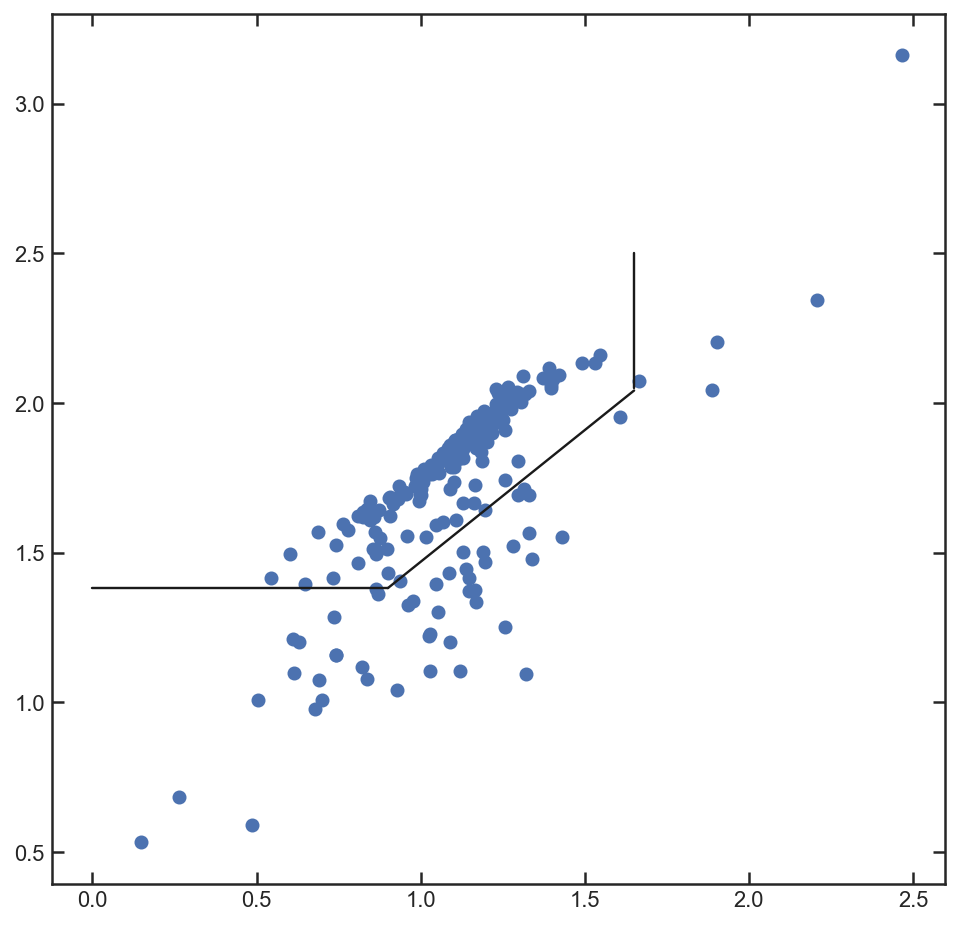

In [4]:
plt.figure(figsize=[8,8])
plt.scatter(Bdb.VJ, Bdb.UV)
plt.scatter(Bdb.VJ, Bdb.UV)
plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
# plt.axis([0,2.5,.5,2.5])

In [10]:
Bdb.query('UV > 2.5')[['field', 'id', 'zgrism']]

,field,id,zgrism
80,GSD,41122,0.390854
